# Introduction

Using convolutional neural networks for classification of tumor tissue in 96x96 RGB pathology images.

Training set contains 220025 images

Test set contains 7458 images

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scikeras.wrappers import KerasClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import tf2onnx
import onnx

Load data

In [3]:
df_train = pd.read_csv('./train_labels.csv')
df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
df_test = pd.read_csv('./sample_submission.csv')
df_test.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


Check for missing values

In [5]:
df_train.isna().sum()

id       0
label    0
dtype: int64

In [6]:
df_test.isna().sum()

id       0
label    0
dtype: int64

Check for duplicated values

In [7]:
df_train.duplicated().sum()

0

In [8]:
df_test.duplicated().sum()

0

Examine label distribution

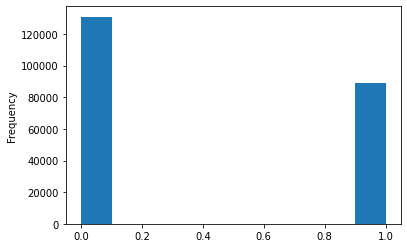

In [9]:
df_train['label'].plot.hist();

Examine data images

In [10]:
sample_img = Image.open('./train/'+df_train.iloc[0]['id']+'.tif')
print(f'Width:{sample_img.width} Height:{sample_img.height} Mode: {sample_img.mode} Palette: {sample_img.palette}')

Width:96 Height:96 Mode: RGB Palette: None


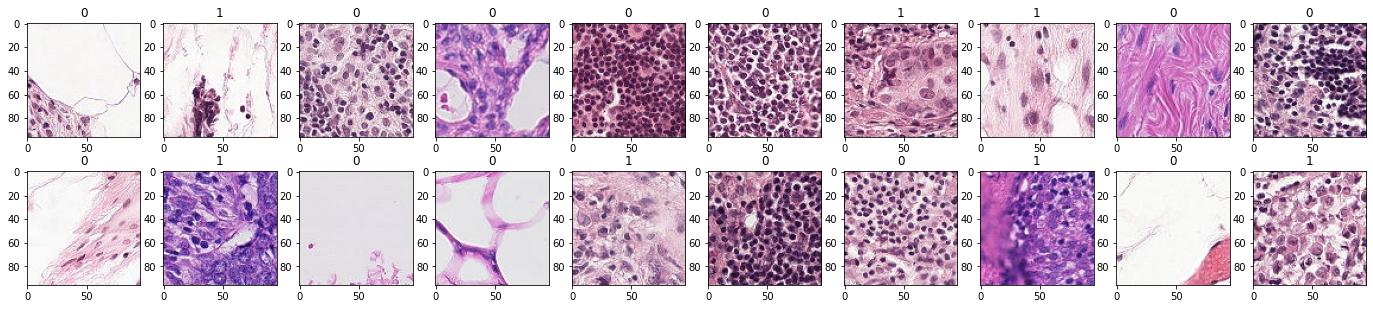

In [11]:
plt.figure(figsize=(24,5))
for i in range(20):
    plt.subplot(2,10,i+1)
    img = plt.imread('./train/'+df_train.iloc[i]['id']+'.tif')
    plt.imshow(img)
    plt.title(df_train.iloc[i]['label'])

# Preprocessing

Perform preprocessing to prepare for model building by loading images as arrays.

First append .tif to each id to create a valid filepath to each image. Also convert the label filetype to `string` to be of the correct format for data generator.

In [12]:
df_train['image'] = df_train['id'].apply(lambda x: x + '.tif')
df_train['label'] = df_train['label'].astype(str)
df_train.head()

,id,label,image
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif


In [34]:
df_test['image'] = df_test['id'].apply(lambda x: x + '.tif')
df_test['label'] = df_test['label'].astype(str)
df_test.head()

,id,label,image
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif
1,95596b92e5066c5c52466c90b69ff089b39f2737,1,95596b92e5066c5c52466c90b69ff089b39f2737.tif
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,1,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif
3,2c35657e312966e9294eac6841726ff3a748febf,1,2c35657e312966e9294eac6841726ff3a748febf.tif
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif


Split the training dataset into training and validation datasets, use 15% for validation set.

Fix seed with 1, stratify on label.

In [14]:
train, val = train_test_split(df_train, test_size=0.15, random_state=1, stratify=df_train['label'])

Create generators for training, validation and test sets, also include rotation, horizontal and vertical shifting and zooming on images to prevent overfitting.

In [15]:
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10, #Rotate images randomly by 10 degrees
    width_shift_range=0.1, #Horizontally shift images randomly by 10%
    height_shift_range=0.1, #Vertically shift images randomly by 10%
    zoom_range=0.1, #Zoom images randomly by 10%
    fill_mode='nearest', #Fill missing pixels with nearest pixel values
)
generator_train = datagen_train.flow_from_dataframe(
    dataframe=train,
    directory='./train',
    x_col='image',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

Found 187021 validated image filenames belonging to 2 classes.


In [16]:
datagen_val = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
generator_val = datagen_val.flow_from_dataframe(
    dataframe=val,
    directory='./train',
    x_col='image',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

Found 33004 validated image filenames belonging to 2 classes.


In [35]:
datagen_test = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
generator_test = datagen_test.flow_from_dataframe(
    dataframe=df_test,
    directory='./test',
    x_col='image',
    y_col='label',
    target_size=(96, 96),
    batch_size=32
)

Found 57458 validated image filenames belonging to 2 classes.


# Create initial model

Use a CNN with three layers with 3x3 filter to have three different fields of view and three levels of detail to find tumor cells.

Tested with larger kernels on first filter, but performance decreased.

Also tested different architectures and normalization layers.

In [19]:
def get_model():
    optimizer = Adagrad(learning_rate=0.001, epsilon=1e-7, use_ema=True, ema_momentum=0.99)
    model = Sequential(name='sequential_model')
    model.add(Conv2D(32, kernel_size=3, activation='relu', padding = 'Same', input_shape=(96,96,3)))
    model.add(Conv2D(32, kernel_size=3, activation='relu', padding = 'Same'))
    model.add(Conv2D(32, kernel_size=3, activation='relu', padding = 'Same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(64, kernel_size=3, activation='relu', padding = 'Same'))
    model.add(Conv2D(64, kernel_size=3, activation='relu', padding = 'Same'))
    model.add(Conv2D(64, kernel_size=3, activation='relu', padding = 'Same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Conv2D(128, kernel_size=3, activation='relu', padding = 'Same'))
    model.add(Conv2D(128, kernel_size=3, activation='relu', padding = 'Same'))
    model.add(Conv2D(128, kernel_size=3, activation='relu', padding = 'Same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(units=64,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(units=64,activation="relu"))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

get_model().summary()

Model: "sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 conv2d_10 (Conv2D)          (None, 96, 96, 32)        9248      
                                                                 
 conv2d_11 (Conv2D)          (None, 96, 96, 32)        9248      
                                                                 
 batch_normalization_3 (Bat  (None, 96, 96, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 48, 48, 64)   

Initial model, RMSprop optimizer accuracy, 1 epoch: loss: 0.4304 - accuracy: 0.8159 - val_loss: 1.5696 - val_accuracy: 0.6216

Initial model, Adam optimizer accuracy, 1 epoch: loss: 0.4212 - accuracy: 0.8169 - val_loss: 0.4178 - val_accuracy: 0.8027

Initial model, Adagrad optimizer accuracy, 1 epoch: loss: 0.4057 - accuracy: 0.8209 - val_loss: 0.3561 - val_accuracy: 0.8424

After these initial, Adagrad was selected as the optimizer for the final model.

Next several iterations of grid search was performed in order to obtain the selected hyperparameters for the optimizer.

In [27]:
model = get_model()
epochs = 10
history = model.fit(generator_train, validation_data=generator_val, epochs=epochs)

Epoch 1/10
5845/5845 [==============================] - 1171s 200ms/step - loss: 0.3994 - accuracy: 0.8244 - val_loss: 0.3438 - val_accuracy: 0.8494
Epoch 2/10
5845/5845 [==============================] - 614s 105ms/step - loss: 0.3390 - accuracy: 0.8550 - val_loss: 0.3134 - val_accuracy: 0.8663
Epoch 3/10
5845/5845 [==============================] - 608s 104ms/step - loss: 0.3110 - accuracy: 0.8692 - val_loss: 0.2983 - val_accuracy: 0.8734
Epoch 4/10
5845/5845 [==============================] - 611s 105ms/step - loss: 0.2883 - accuracy: 0.8815 - val_loss: 0.2649 - val_accuracy: 0.8931
Epoch 5/10
5845/5845 [==============================] - 607s 104ms/step - loss: 0.2708 - accuracy: 0.8898 - val_loss: 0.2633 - val_accuracy: 0.8910
Epoch 6/10
5845/5845 [==============================] - 609s 104ms/step - loss: 0.2602 - accuracy: 0.8942 - val_loss: 0.2655 - val_accuracy: 0.8875
Epoch 7/10
5845/5845 [==============================] - 634s 109ms/step - loss: 0.2517 - accuracy: 0.8984 - val

Text(0, 0.5, 'Accuracy')

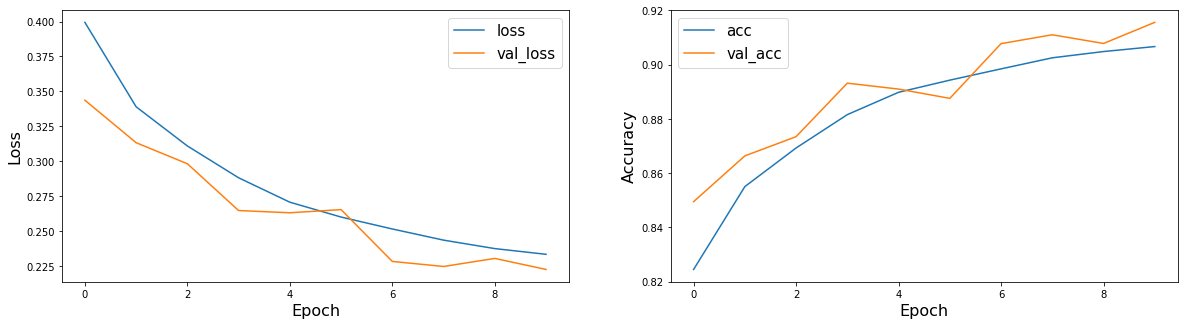

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].legend(['loss', 'val_loss'],fontsize=15)
ax[0].set_xlabel('Epoch',fontsize=16)
ax[0].set_ylabel('Loss',fontsize=16)
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].legend(['acc', 'val_acc'],fontsize=15)
ax[1].set_xlabel('Epoch',fontsize=16)
ax[1].set_ylabel('Accuracy',fontsize=16)

Make predictions on test set:

In [44]:
predicted_labels = model.predict(generator_test)

1796/1796 [==============================] - 56s 31ms/step


In [43]:
df_test['label'] = np.round(predicted_labels.flatten()).astype('int')
df_test['label'].value_counts()

0    42788
1    14670
Name: label, dtype: int64

In [38]:
df_test.drop(['image'], axis=1).to_csv('predictions.csv', index=False)

In [28]:
# Save model
model.save('Complete.keras')

onnx_model, _ = tf2onnx.convert.from_keras(model, opset=13)
onnx.save(onnx_model, "model.onnx")

# Results
Very first submission only received a private score of 0.499, and a public score of 0.035. This was with only two layers of filters, with the first having a 5x5 filter, no batchnorm or dropout layers.

After tuning the model architecture, and optimizer, the final submission received a score of a private score of 0.501, and a public score of 0.4996, but had much higher train and validation accuracy, and much lower train and validation loss. There is a possibility some procedure was done incorrectly for prediction and/or validation.

